## Setup

In [2]:
# don't use separate window for visualizations
%matplotlib inline

# Import our packages
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")
from IPython.core.display import HTML
from wordcloud import WordCloud

import json
from bs4 import BeautifulSoup
import requests
import re

# Scraping

*Note: some of the code in this initial scraping portion was used from a past CS109 problem set, in which the BeautifulSoup package was used to scrape Wikipedia.*

Cool. Okay, the plan is to go to the webpages of the Billboard Top 100 for each year on Wikipedia, and scrape information about each song's title, ranking, artist, and url. We'll store this all in a big dictionary then convert it to a dataframe. Then, we'll go to each artist's URL and get more information from those Wikipedia pages.

First, I'll save the HTML of all the webpages in a dictionary (using all lists starting from 1959, since this was the first year that they had 100 songs on their list):

In [7]:
years = range(1959,2017)
html_list = []
for year in years:
	req = requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_%d" % year)
	html_list.append(BeautifulSoup(req.text, "html.parser"))
	time.sleep(1)

years_html = dict(zip(years, text_list))

Cool--now we can try parsing through each one of these webpages and making a dictionary out of it:

In [8]:
def parse_year(year, yeartextdict):
	print year
	my_text = yeartextdict[year]

	# define fields for dictionaries
	fields = ["band_singer", "ranking", "song", "songurl", "titletext", "url"]
	
	# make list of rows
	rows = my_text.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]

    # define a function that formats data and cleans up some random exceptions
	def cleaner(r):
        # get ranking
		ranking = r[0].get_text()
        
		# format as integer, if not tie (we'll do some post-hoc formatting of this later)
		if(r[0].get_text() != 'Tie'):
			ranking = int(ranking)

		# get song title & url - if no <a> tag, then don't give a songurl
		if(r[1].find_all("a") == []):
			song = [r[1].get_text().replace('"', '').strip()]
			songurl = [None]
			titletext = r[1].get_text()
		else:
			song = [title.get_text() for title in r[1].find_all("a")]
			songurl = [link.get("href") for link in r[1].find_all("a")]
			titletext = '"' + song[0] + '"'
			if len(song)==2: titletext = titletext + '/"' + song[1] + '"'

        # get singer & url
		band_singer = [artist.get_text() for artist in r[2].find_all("a")]
		url = [link2.get("href") for link2 in r[2].find_all("a")]

        # return all as a list
		return [band_singer, ranking, song, songurl, titletext, url]


	# go through each row and create dictionary by zipping (FYI - some rankings have "th" tag)
	songs = [dict(zip(fields, cleaner(row.find_all("th") + row.find_all("td")))) for row in rows]
	return songs

Awesome, this works. Now it's time to parse through each year and store the data from all years into a central dictionary:

In [10]:
yearinfo = {y:parse_year(y, years_html) for y in years}

1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


Since there were some ties, and the function I wrote made it hard to enumerate these ties, we're going to do a post-hoc format of all the tied rankings:

In [11]:
yearinfo[1969][100]['ranking'] = 100
yearinfo[1974][37]['ranking'] = 37
yearinfo[1974][54]['ranking'] = 54
yearinfo[1974][85]['ranking'] = 85
yearinfo[1974][91]['ranking'] = 91

Awesome. Now time to see if we can make this into some kind of dataframe.

In [12]:
yeardict={}
for y in yearinfo.keys():
    yearlist=yearinfo[y]
    yearlist2=[]
    for idict in yearlist:
        singers=idict['band_singer']
        for i,s in enumerate(singers):
            songs=idict['song']
            for j,so in enumerate(songs):#now inside each singer song combination
                nd={}
                nd['band_singer']=s
                nd['url']=idict['url'][i]
                nd['song']=so
                nd['songurl']=idict['songurl'][j]
                nd['ranking']=idict['ranking']
                yearlist2.append(nd)
    yeardict[y]=pd.DataFrame(yearlist2)#one for each year
yearspanel=pd.Panel.from_dict(yeardict, orient="minor")#stack dataframes into a panel
hierframe=yearspanel.to_frame() #flattening leads to a hierarchical index

In [13]:
hierframe.head()

band_singer  ranking                       song                          songurl                  url
major minor                                                                                                         
0     1959   Johnny Horton        1  The Battle of New Orleans  /wiki/The_Battle_of_New_Orleans  /wiki/Johnny_Horton
      1960     Percy Faith        1  Theme from A Summer Place  /wiki/Theme_from_A_Summer_Place    /wiki/Percy_Faith
      1961     Bobby Lewis        1        Tossin' and Turnin'    /wiki/Tossin%27_and_Turnin%27    /wiki/Bobby_Lewis
      1962      Acker Bilk        1      Stranger on the Shore      /wiki/Stranger_on_the_Shore     /wiki/Acker_Bilk
      1963   The Fireballs        1                Sugar Shack                /wiki/Sugar_Shack  /wiki/The_Fireballs

Time to flatten this dataframe:

In [14]:
# reset index
musicframe = hierframe.reset_index()
# rename year column
musicframe = musicframe.rename(columns={'minor':'year'})
# delete major column
del musicframe['major']
# sort by year & ranking
musicframe=musicframe.sort_values(by=['year', 'ranking'])

# let's check it out
musicframe.head()

,year,band_singer,ranking,song,songurl,url
0,1959,Johnny Horton,1,The Battle of New Orleans,/wiki/The_Battle_of_New_Orleans,/wiki/Johnny_Horton
58,1959,Bobby Darin,2,Mack the Knife,/wiki/Mack_the_Knife,/wiki/Bobby_Darin
116,1959,Lloyd Price,3,Personality,/wiki/Personality_(Lloyd_Price_song),/wiki/Lloyd_Price
174,1959,Frankie Avalon,4,Venus,/wiki/Venus_(Frankie_Avalon_song),/wiki/Frankie_Avalon
232,1959,Paul Anka,5,Lonely Boy,/wiki/Lonely_Boy_(Paul_Anka_song),/wiki/Paul_Anka


Cool, now it's time to start going through the URLs of each artist and getting further information about each them. First we'll see if we can make a cache for our URLs so we don't have to do multiple GET requests, and then define a function to store the artist's webpage HTML:

In [15]:
urlcache = {}
def get_page(url):
    # if URL not in cache, then download HTML
    if (url not in urlcache) or (urlcache[url]==1) or (urlcache[url]==2):
        time.sleep(1)
        # try request
        try:
            r = requests.get("http://en.wikipedia.org%s" % url)

            if r.status_code == 200:
                urlcache[url] = r.text
            else:
                urlcache[url] = 1
        except:
            urlcache[url] = 2
    return urlcache[url]

In [16]:
musicframe["url"].apply(get_page)

0       <!DOCTYPE html>\n<html class="client-nojs" lan...
58      <!DOCTYPE html>\n<html class="client-nojs" lan...
116     <!DOCTYPE html>\n<html class="client-nojs" lan...
174     <!DOCTYPE html>\n<html class="client-nojs" lan...
232     <!DOCTYPE html>\n<html class="client-nojs" lan...
290     <!DOCTYPE html>\n<html class="client-nojs" lan...
348     <!DOCTYPE html>\n<html class="client-nojs" lan...
406     <!DOCTYPE html>\n<html class="client-nojs" lan...
464     <!DOCTYPE html>\n<html class="client-nojs" lan...
522     <!DOCTYPE html>\n<html class="client-nojs" lan...
580     <!DOCTYPE html>\n<html class="client-nojs" lan...
638     <!DOCTYPE html>\n<html class="client-nojs" lan...
695     <!DOCTYPE html>\n<html class="client-nojs" lan...
752     <!DOCTYPE html>\n<html class="client-nojs" lan...
809     <!DOCTYPE html>\n<html class="client-nojs" lan...
867     <!DOCTYPE html>\n<html class="client-nojs" lan...
925     <!DOCTYPE html>\n<html class="client-nojs" lan...
981     <!DOCT

Wow, that took like 30 minutes to do. Best to save the `urlcache` in a file so that we never have to go through that again:

In [17]:
with open("tempdata/song_artist_info.json","w") as fd:
    json.dump(urlcache, fd)

In [36]:
np.save('artist_html_text.npy', urlcache) 

# if we want to load again:
# read_dictionary = np.load('my_file.npy').item()

Now it's time to take all this HTML and see what data we can get from it--most importantly, genres:

In [24]:
def artist_info(url, text):
	# set default values & names for each key
	ya = False
	genres = ['NA']

	fields = ["url", "genres", "ya"]
	my_text = BeautifulSoup(text, "html.parser")

	# get list of main rows from table; if table doesn't exist, there's no info on the band/artist so return all default values
	try: rows = my_text.find("table", attrs={"class": ["infobox", "vcard"]}).find_all("tr")[1:]
	except: return dict(zip(fields, [url, genres, ya]))

    
    #go through each row
	for row in rows:
		label = row.find("th", attrs={"scope": "row"})
		
        #if there is a "th" section (aka no error thrown)
		try:
			#if the text of "th" section has "years" & "active"
			if "Years" and "active" in label.get_text():
                # get the text from "td" portion and remove unicode gibberish
				ya = row.find("td").get_text().replace(u'\u2013', '-').replace(u'\xa0','').replace("\n\n\n", "").replace("\n", ", ").replace("~","-").encode('latin-1')
                # remove all text within [] and () -- this is due to links/references getting caught in the text
				ya = re.sub(r'\([^)]*\)', '', ya)
				ya = re.sub("[\(\[].*?[\)\]]", "", ya)
                
            #if the text of "th" section has "Genres", get the corresponding link(s) and make sure it's a wiki link
			if label.get_text() == "Genres":
				genres = [part.get("href") for part in row.find_all("a") if 'wiki' in part.get("href")][1:]
		except: None
    
    #return dictionary
	return dict(zip(fields, [url, genres, ya]))

Testing it out:

In [25]:
artist_info("/wiki/Spice_Girls", urlcache["/wiki/Spice_Girls"])

{'genres': [u'/wiki/Dance-pop', u'/wiki/Teen_pop'],
 'url': '/wiki/Spice_Girls',
 'ya': '1994-2000, 2007-08, 2012, 2016'}

Yay! Alright, now time to see how we can merge this into our data. First we'll make a list, then go from there:

In [26]:
artist_info_list=[]
for k,v in urlcache.items():
    artist_info_list.append(artist_info(k, v))

Now let's merge this with our original dataframe:

In [28]:
tempdf=pd.DataFrame(artist_info_list)
master_df=musicframe.merge(tempdf, on="url")
master_df.head()

,year,band_singer,ranking,song,songurl,url,genres,ya
0,1959,Johnny Horton,1,The Battle of New Orleans,/wiki/The_Battle_of_New_Orleans,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960
1,1960,Johnny Horton,28,Sink the Bismarck,/wiki/Sink_the_Bismarck_(song),/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960
2,1960,Johnny Horton,80,North to Alaska,/wiki/North_to_Alaska,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960
3,1959,Bobby Darin,2,Mack the Knife,/wiki/Mack_the_Knife,/wiki/Bobby_Darin,"[/wiki/Blues, /wiki/Rock_%27n%27_roll, /wiki/P...",1956-1973
4,1959,Bobby Darin,6,Dream Lover,/wiki/Dream_Lover,/wiki/Bobby_Darin,"[/wiki/Blues, /wiki/Rock_%27n%27_roll, /wiki/P...",1956-1973


But now the genre data is weird. It's in a list, and to work with it we'll probably want to make a lot of genre indicator variables. So let's see if there's a way we can make that happen:

In [29]:
genre_list = set()

# update our genres in our set
for row in master_df.genres:
	genre_list.update(link for link in row)

genre_list = sorted(genre_list)

# make a bunch of new columns for new genres
for genre in genre_list:
	master_df[genre] = [genre in artist for artist in master_df.genres]

del master_df['NA']

master_df.head()

,year,band_singer,ranking,song,songurl,url,genres,ya,/wiki/2_Tone,/wiki/A_cappella,/wiki/Acid_jazz,/wiki/Acid_rock,/wiki/Acoustic_hip_hop,/wiki/Acoustic_music,/wiki/Acoustic_rock,/wiki/Adult_Contemporary,/wiki/Adult_Contemporary_Music,/wiki/Adult_contemporary,/wiki/Adult_contemporary_music,/wiki/African_popular_music,/wiki/Album-oriented_rock,/wiki/Alternative_Country,/wiki/Alternative_R%26B,/wiki/Alternative_country,/wiki/Alternative_dance,/wiki/Alternative_hip_hop,/wiki/Alternative_metal,/wiki/Alternative_music,/wiki/Alternative_pop,/wiki/Alternative_rock,/wiki/Alternative_rock_music,/wiki/Ambient_music,/wiki/Americana_(music),/wiki/Anarcho-punk,/wiki/Anti-folk,/wiki/Arena_rock,/wiki/Art_pop,/wiki/Art_punk,/wiki/Art_rock,/wiki/Avant-garde_music,/wiki/Avant-pop,/wiki/Baggy,/wiki/Baroque_pop,/wiki/Bass_music,/wiki/Beach_music,/wiki/Beat_music,/wiki/Bebop,/wiki/Bhangra_(music),/wiki/Big_band,/wiki/Big_room_house,...,/wiki/Swamp_rock,/wiki/Swing_(genre),/wiki/Swing_(music),/wiki/Swing_music,/wiki/Symphonic_pop,/wiki/Symphonic_rock,/wiki/Synth-pop,/wiki/Synthpop,/wiki/Synthwave_(2000s_genre),/wiki/Talking_blues,/wiki/Tech_house,/wiki/Techno,/wiki/Teen_pop,/wiki/Tejano_music,/wiki/Theatre_music,/wiki/Third_stream,/wiki/Thrash_metal,/wiki/Trad_jazz,/wiki/Traditional_pop,/wiki/Traditional_pop_music,/wiki/Traditional_popular_music,/wiki/Trance_music,/wiki/Trap_music,/wiki/Trip_hop,/wiki/Truck-driving_country,/wiki/UK_funky,/wiki/UK_garage,/wiki/Underground_hip_hop,/wiki/Urban_adult_contemporary,/wiki/Urban_contemporary,/wiki/Urban_contemporary_gospel,/wiki/Urban_music,/wiki/Vocal_Group,/wiki/Vocal_jazz,/wiki/Vocal_music,/wiki/Vocalese,/wiki/Wagnerian_rock,/wiki/West_Coast_hip_hop,/wiki/West_Coast_jazz,/wiki/West_coast_hip_hop,/wiki/Western_Swing,/wiki/Western_music_(North_America),/wiki/Western_swing,/wiki/Wonky_(music),/wiki/World_Music,/wiki/World_music,/wiki/Worldbeat,/wiki/Worship_music,/wiki/Yacht_rock,/wiki/Zydeco
0,1959,Johnny Horton,1,The Battle of New Orleans,/wiki/The_Battle_of_New_Orleans,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1960,Johnny Horton,28,Sink the Bismarck,/wiki/Sink_the_Bismarck_(song),/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1960,Johnny Horton,80,North to Alaska,/wiki/North_to_Alaska,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [37]:
master_df.to_csv('song_artist_df.csv', index=False, encoding='utf-8')

## Lil' Bit of Visualizations

We can first load our dataset back in:

In [2]:
master_df = pd.read_csv('song_artist_df.csv')

In [3]:
master_df.head()

,year,band_singer,ranking,song,songurl,url,genres,ya,/wiki/2_Tone,/wiki/A_cappella,/wiki/Acid_jazz,/wiki/Acid_rock,/wiki/Acoustic_hip_hop,/wiki/Acoustic_music,/wiki/Acoustic_rock,/wiki/Adult_Contemporary,/wiki/Adult_Contemporary_Music,/wiki/Adult_contemporary,/wiki/Adult_contemporary_music,/wiki/African_popular_music,/wiki/Album-oriented_rock,/wiki/Alternative_Country,/wiki/Alternative_R%26B,/wiki/Alternative_country,/wiki/Alternative_dance,/wiki/Alternative_hip_hop,/wiki/Alternative_metal,/wiki/Alternative_music,/wiki/Alternative_pop,/wiki/Alternative_rock,/wiki/Alternative_rock_music,/wiki/Ambient_music,/wiki/Americana_(music),/wiki/Anarcho-punk,/wiki/Anti-folk,/wiki/Arena_rock,/wiki/Art_pop,/wiki/Art_punk,/wiki/Art_rock,/wiki/Avant-garde_music,/wiki/Avant-pop,/wiki/Baggy,/wiki/Baroque_pop,/wiki/Bass_music,/wiki/Beach_music,/wiki/Beat_music,/wiki/Bebop,/wiki/Bhangra_(music),/wiki/Big_band,/wiki/Big_room_house,...,/wiki/Swamp_rock,/wiki/Swing_(genre),/wiki/Swing_(music),/wiki/Swing_music,/wiki/Symphonic_pop,/wiki/Symphonic_rock,/wiki/Synth-pop,/wiki/Synthpop,/wiki/Synthwave_(2000s_genre),/wiki/Talking_blues,/wiki/Tech_house,/wiki/Techno,/wiki/Teen_pop,/wiki/Tejano_music,/wiki/Theatre_music,/wiki/Third_stream,/wiki/Thrash_metal,/wiki/Trad_jazz,/wiki/Traditional_pop,/wiki/Traditional_pop_music,/wiki/Traditional_popular_music,/wiki/Trance_music,/wiki/Trap_music,/wiki/Trip_hop,/wiki/Truck-driving_country,/wiki/UK_funky,/wiki/UK_garage,/wiki/Underground_hip_hop,/wiki/Urban_adult_contemporary,/wiki/Urban_contemporary,/wiki/Urban_contemporary_gospel,/wiki/Urban_music,/wiki/Vocal_Group,/wiki/Vocal_jazz,/wiki/Vocal_music,/wiki/Vocalese,/wiki/Wagnerian_rock,/wiki/West_Coast_hip_hop,/wiki/West_Coast_jazz,/wiki/West_coast_hip_hop,/wiki/Western_Swing,/wiki/Western_music_(North_America),/wiki/Western_swing,/wiki/Wonky_(music),/wiki/World_Music,/wiki/World_music,/wiki/Worldbeat,/wiki/Worship_music,/wiki/Yacht_rock,/wiki/Zydeco
0,1959,Johnny Horton,1,The Battle of New Orleans,/wiki/The_Battle_of_New_Orleans,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1960,Johnny Horton,28,Sink the Bismarck,/wiki/Sink_the_Bismarck_(song),/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1960,Johnny Horton,80,North to Alaska,/wiki/North_to_Alaska,/wiki/Johnny_Horton,"[/wiki/Honky-tonk, /wiki/Rockabilly]",1950-1960,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

Now time to see what our data looks like. First let's take a little look at genre frequency:

In [4]:
# get the mean of each column
genre_score = master_df.mean(axis=0)*100
# take out the first two columns (ranking and year)--we just want the frequency of the genres
genre_score = genre_score[2:].sort_values(ascending=False)

In [5]:
# reset index to get the names of our genres in a column of its own; take the top 30 and store it in a new dataframe so we don't
# mess up our original
plot_df = genre_score.reset_index()[:30]
# make the genre names pretty
plot_df["index"] = [row.replace("/wiki/","").replace("_", " ").replace("%26","&") for row in plot_df["index"]]
# rename a column and check out the df
plot_df.rename(columns={0:'points'}, inplace=True)
plot_df.head()

,index,points
0,Pop music,22.101337
1,Soul music,13.988188
2,Contemporary R&B,9.558595
3,Hip hop music,8.190861
4,Pop rock,8.050979


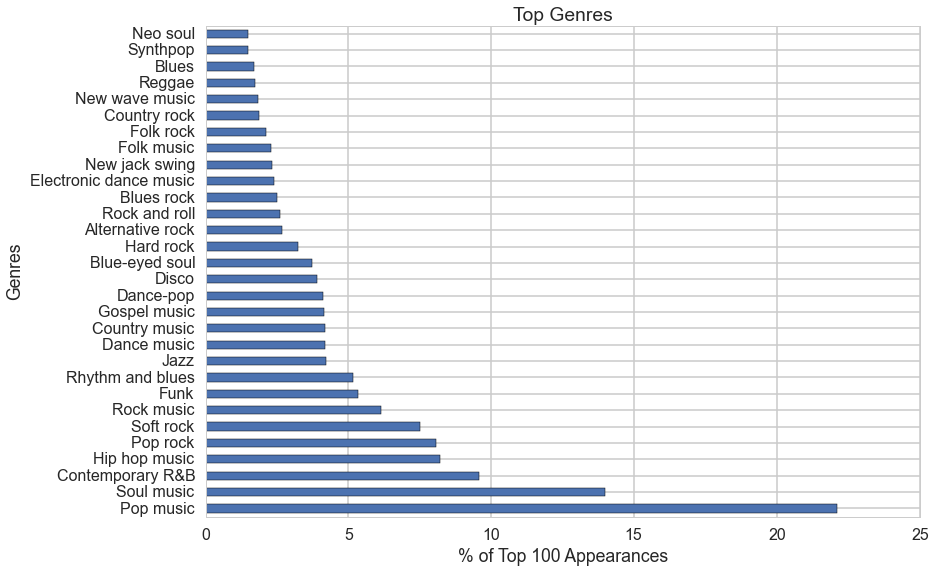

In [6]:
#all good, now let's plot!
plot_df.plot(x="index", y="points", kind="barh", legend = None).set_ylabel("Genres")
plt.xlabel("% of Top 100 Appearances")
plt.title("Top Genres")

Let's have some fun with a Word Cloud. First we'll have to get all the genre names into a big string and then feed them into our Word Cloud package:

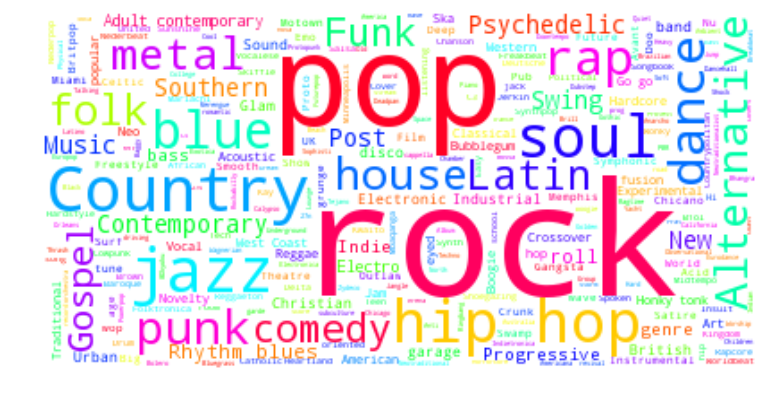

In [7]:
# get list of all genres
music_text = list(master_df)[8:]
# collapse into a single string and format weird characters (also, take out the word "music")
music_text_form = ' '.join(music_text).replace("/wiki/","").replace("_", " ").replace("%26","&").replace("music","")

# Generate word cloud image and plot
wordcloud = WordCloud(background_color="white", max_words=2000).generate(music_text_form)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now we can make a dictionary that stores series data for each genre throughout the years. We can make a cool set of graphs if we get the average ranking (and the ranking SD) for each year and then plot this over time:

In [8]:
# Initialize dictionary
genreinfo={}
# get top 24 genres
topgenres=genre_score.index[:15]

# loop through each genre
for genre in topgenres:
    # in each row where genre exists, get ranking and year
    genreframe=master_df[master_df[genre]==True][['ranking','year']]
    # group by year
    ggby = genreframe.groupby('year')
    # input another dictionary into our existing dictionary, with series data on ranking means & SDs
    genreinfo[genre]={'meanseries': ggby['ranking'].mean(), 'stdseries': ggby['ranking'].std(), 'rankingseries': ggby['ranking']}

Now time to make our graphs. We're going to make a grid of the popularity of the top 15 most common genres over time:

C:\Users\Bri Bri\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
C:\Users\Bri Bri\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


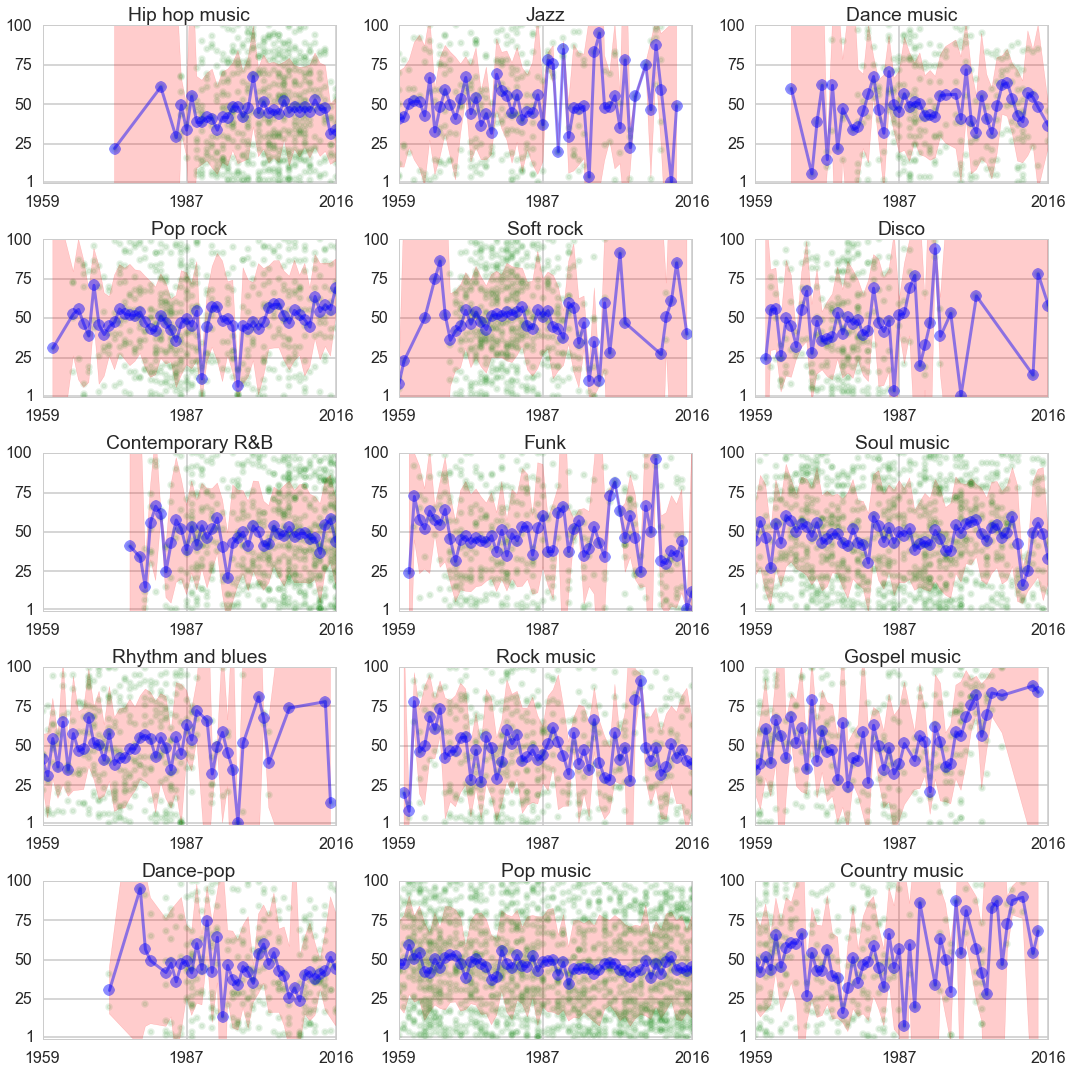

In [9]:
#set up subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15), tight_layout=True)
plt.setp(axes, xticks=[1959,1987,2016], yticks=[1, 25, 50, 75,100])

# go through each plot and genre
for ax, genre in zip(axes.ravel(), genreinfo):
    hai = genreinfo[genre]
    
    # plot means connected by lines
    ax.plot(hai["meanseries"].index, hai["meanseries"], 'o-', color='b', lw=3, label='Hai', alpha=.45)
    # replace all SDs that are NaNs with big numbers (100)
    for number in range(0, len(hai['stdseries'].values)):
        if math.isnan(hai['stdseries'].values[number]) == True:
            hai['stdseries'].values[number] = 100
    # fill to represent +/- SD
    ax.fill_between(hai["meanseries"].index, (hai["meanseries"] + hai["stdseries"]).values, (hai["meanseries"] - hai["stdseries"]).values, color='r', alpha=.2)
    # populate individual rankings
    for part in hai["rankingseries"]:
        for year in part:
            ax.scatter(np.repeat(part[0], len(part[1])), part[1], alpha=.05, lw=3, color='g')
    ax.set_ylim(0, 100)
    ax.set_xlim(1959, 2016)
    ax.set_title(genre.replace("/wiki/","").replace("_", " ").replace("%26","&"))
    

## Network Graph - Data Setup

Now, in order to set up our network analysis, we need two new dataframes: one with our nodes, and another with our edges. We can then convert these dataframes into JSON formats, which we can then use to read in as JavaScript objects when we make the website visualization. The nodes of the network will be the different genres, and the edges will be when genres appear together. The "strength" or size of each node will be determined by its frequency in the charts, and the strength of the edges will be determined by how many times the genres appear together.

In order to do this, we first need to assign ID numbers to each of the unique genres:

In [5]:
# first, our nodes-- this can be done using a similar tactic to our plot_df
nodes = genre_score.reset_index()
# make the genre names pretty
nodes["label"] = [row.replace("/wiki/","").replace("_", " ").replace("%26","&") for row in nodes["index"]]
# rename other columns
nodes.rename(columns={0:'value'}, inplace=True)
# add id column
nodes["id"] = range(1, nodes.shape[0]+1)
# check it out
nodes.head()

,index,value,label,id
0,/wiki/Pop_music,22.101337,Pop music,1
1,/wiki/Soul_music,13.988188,Soul music,2
2,/wiki/Contemporary_R%26B,9.558595,Contemporary R&B,3
3,/wiki/Hip_hop_music,8.190861,Hip hop music,4
4,/wiki/Pop_rock,8.050979,Pop rock,5


Next, we can create our edges and measure their strength by iterating through our big dataframe:

In [22]:
# Now our edges--their values will be based on the number of times each genre pair appears together
edges = pd.DataFrame(columns = ['from', 'to', 'value'])

# iterate through each genre
for genre1 in range(8, 40):
    # go through all other genres after this--this way we'll hit every pair of genres
    for genre2 in range(genre1+1, master_df.shape[1]):
        # subset master_df where genre1 is True
        sub_df = master_df[master_df[master_df.columns[genre1]]==True]
        # get the number of edges by summing all values of genre2 in this subset
        value = sum(sub_df[sub_df.columns[genre2]])
        
        # if an edge exists, add it to our edges dataframe
        if value != 0:
            # get first genre id
            from_num = int(nodes['id'][nodes['index']==master_df.columns[genre1]])
            # get second genre id
            to_num = int(nodes['id'][nodes['index']==master_df.columns[genre2]])
            
            #append row to our new edge dataframe
            temp = pd.DataFrame([[from_num, to_num, value]], columns = ['from', 'to', 'value'])
            edges = edges.append(temp)            

Convert to CSV so that we don't have to run through all those computations again:

In [24]:
nodes.to_csv('nodes.csv', index=False, encoding='utf-8')
edges.to_csv('edges.csv', index=False, encoding='utf-8')

In [3]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

Now it's time to get these dataframes in the form of JSON that we want (a list of objects, or in this case initially dictionaries), so that it'll be easily compatible with our website code & the Javascript object array format:

In [5]:
nodes_list = []
edges_list = []

for i in range(0, nodes_df.shape[0]):
    temp_dict = dict(zip(['id', 'label', 'value'], [nodes_df['id'][i], nodes_df['label'][i], nodes_df['value'][i]]))
    nodes_list.append(temp_dict)

for i in range(0, edges_df.shape[0]):
    temp_dict = dict(zip(['from', 'to', 'value'], [edges_df['from'][i], edges_df['to'][i], edges_df['value'][i]]))
    edges_list.append(temp_dict)

And now we merge them into one final dictionary, and save as a JSON!

In [6]:
network_dict = dict({'edges': edges_list, 'nodes': nodes_list})

In [78]:
network_json = open('genre_network.json','w')
network_json.write(json.dumps(network_dict, encoding='UTF-8',default=str))
network_json.close()

## Network Graph - Implementation

That's all for this notebook! Head on over to the Github-hosted site to see the network graph I made, as well as all the code.